### GYM

The gym chain Model Fitness would like to forecast their churn of clients.

* [Open the data file and read the general information](#chapter1)
   
* [Exploratory data analysis](#chapter2)

* [Build a model to predict user churn](#chapter3)

* [Create user clusters](#chapter4)

* [Conclusions and recommendations](#chapter5)
 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/gym_churn_us.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
df.duplicated().sum()

0

We have dataset with 4,000 entries, 14 columns. There are no missing values, and no duplicates.

For convenience let's change column names to lowercase.

In [4]:
df.columns = df.columns.str.lower()

#### EDA<a class="anchor" id="chapter2"></a>

Let's study our dataset.

In [5]:
df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

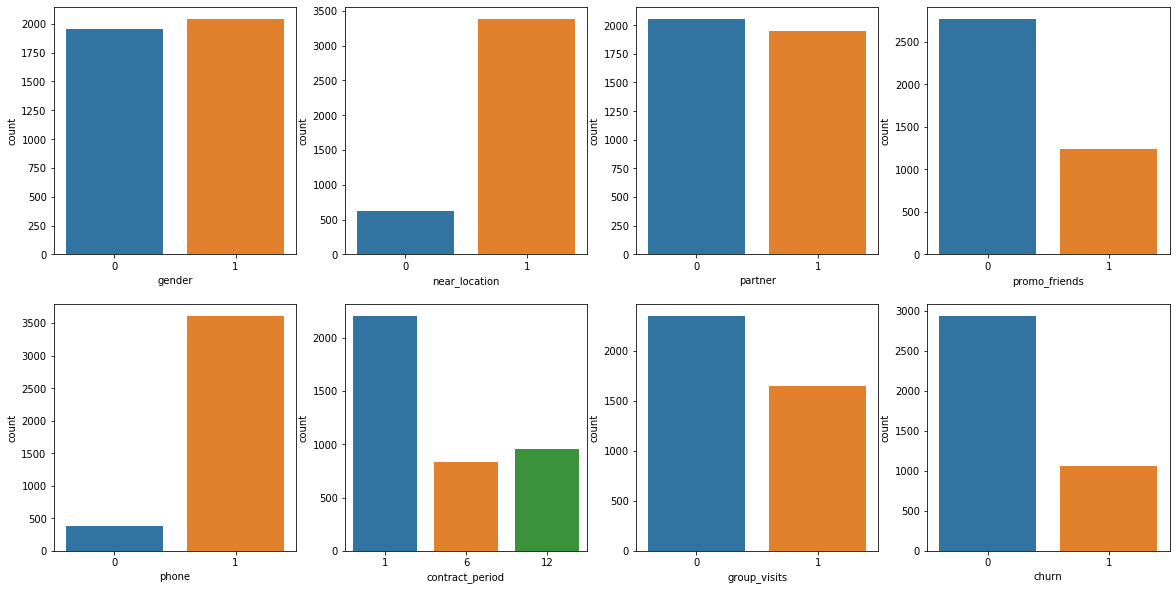

In [6]:
col = ['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits','churn'] 

# Plot bar char
fig , ax = plt.subplots(2,4,figsize=(20,10))

for axis,column in zip(ax.flat,col):
    sns.countplot(x=df[column],ax=axis)

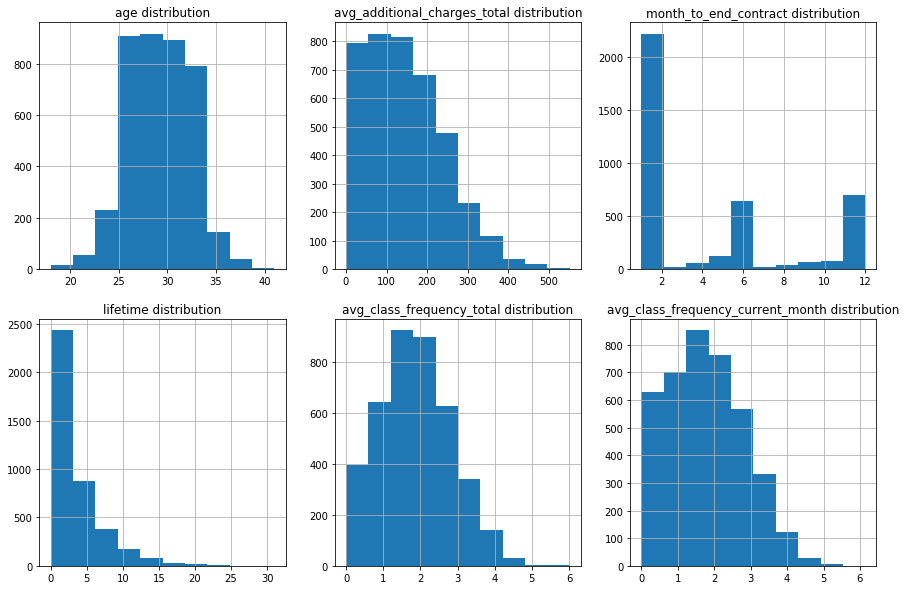

In [7]:
col1 = ['age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month']

# Plot histograms
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(figsize=(15,10),ax=ax)
        ax.set_title(var_name+" distribution")
    plt.show()


draw_histograms(df, col1, 2, 3)

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


There are some conclusions from the graphs and describe() method:

* Both genders are equally represented in the dataset
* 84% of clients live\work near the GYM
* About half of the clients are employees of a partner company
* 30% of the clients came through a "bring a friend" offer  
* 90% of clients left their phone number
* Most of the clients have 1-month contract period
* 41% take part in group sessions
* The age of the clients varies from 18 to 41. The average age is 29 years.
* Most clients tend to spend less than 200 (let's assume dollars) on other gym services: cafe, athletic goods, cosmetics, massages, etc. On average, they spend about 130 dollars in total.
* Most clients have 1 month left till the end of the contract
* Most clients stay with GYM for three month
* On average, clients visit GYM 2 times a week.
* We have 27% of clients that left the company, 73% - stayed with company. We have imbalanced dataset.

Now let's plot bar histograms and feature distributions for those who left (churn) and those who stayed.

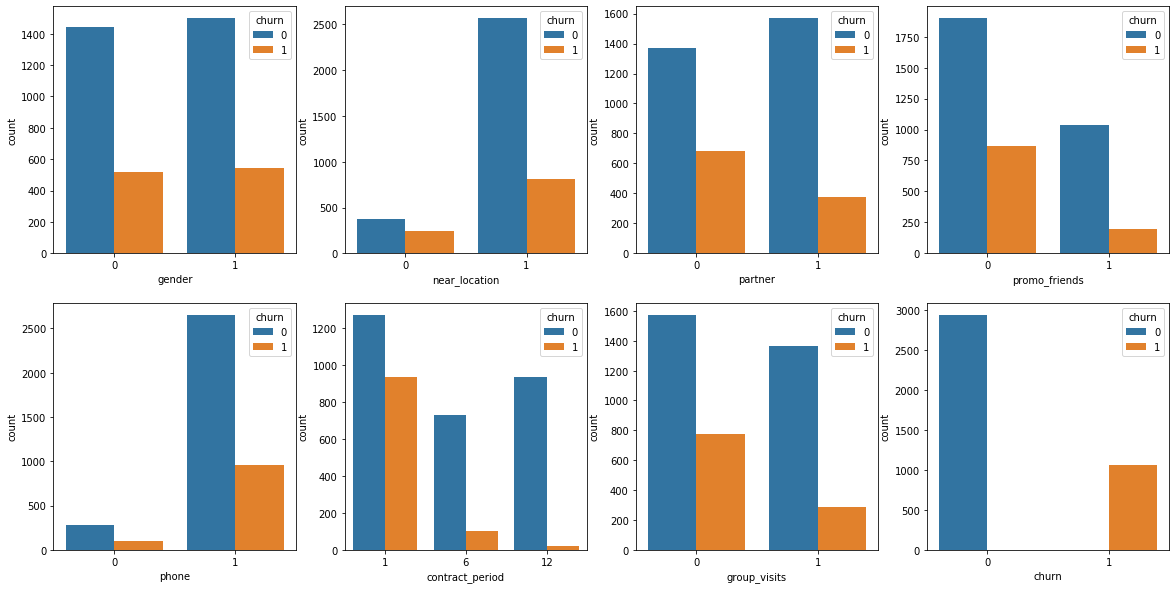

In [9]:
# Plot bar charts 
fig , ax = plt.subplots(2,4,figsize=(20,10))

for axis,column in zip(ax.flat,col):
    sns.countplot(x=df[column],hue = df['churn'], ax=axis)

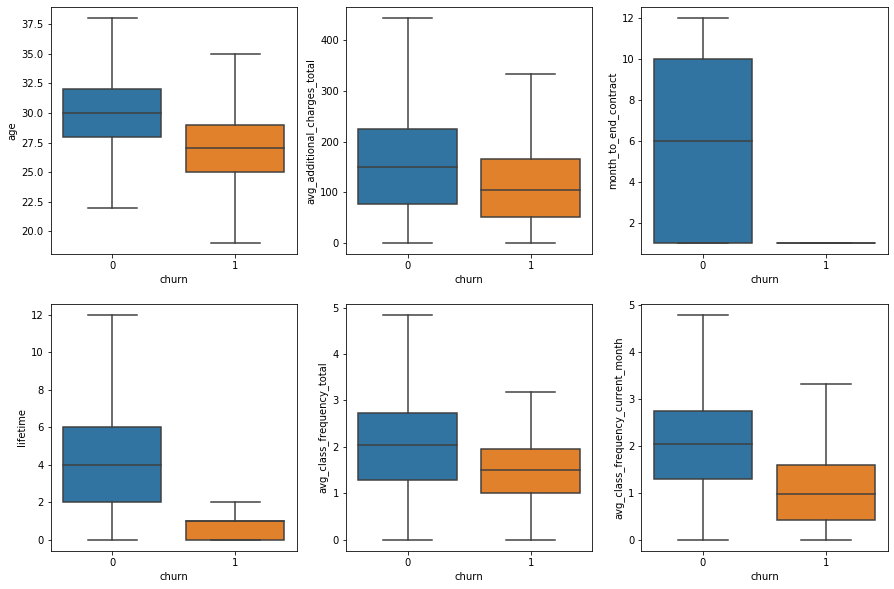

In [10]:
# Plot boxplot for numerical features
fig , ax = plt.subplots(2,3,figsize=(15,10))

for axis,column in zip(ax.flat,col1):
    sns.boxplot(x=df["churn"],y = df[column], ax=axis, showfliers=False)

Now let's look at the mean feature values in two groups: for those who left (churn) and for those who stayed.

In [11]:
df.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


There are some conclusions from the analysis above:

* Gender does not affect the decision to leave the Gym
* Most clients that live\work far from the GYM left
* Clients that are not employees of a partner company more likely to leave
* Those who are not "promo freinds" more likely to leave
* Clients who have 1 month contract more likely to leave
* Those who don't participate in groups visits more likely to leave 
* Average age of clients that are loyal to the GYM is about 30 years, and among those who leave - about 27 years. 
* On average, those who spent less on additional services left
* On average, those who left the company stayed for 1 month. The clients who do not churn, they tend to stay for a longer period (on average 5 months)
* On average, those who come twice a week stay. Those who left came less than twice a week.

Now let's look on correlation matrix.

In [12]:
cm = df.corr()

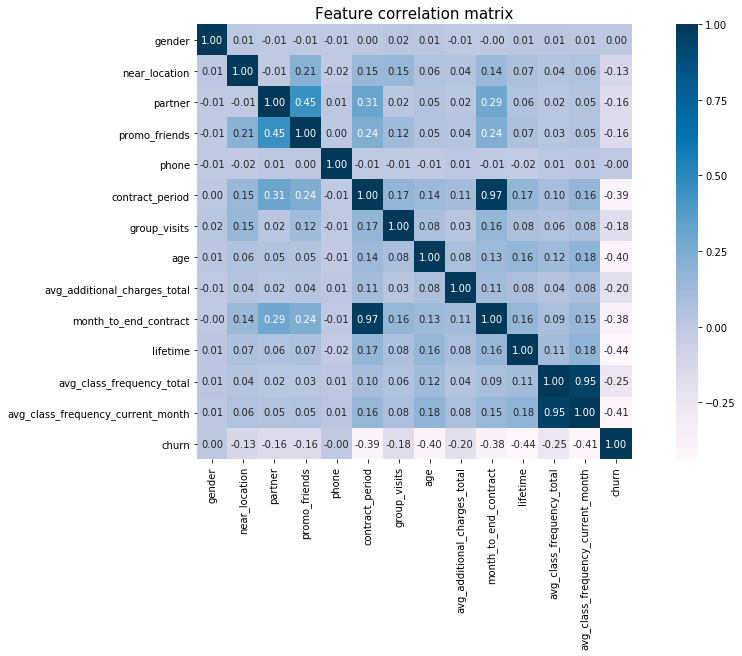

In [13]:
fig, ax = plt.subplots(figsize = (16,8))
plt.title('Feature correlation matrix', fontsize=15) 
sns.heatmap(cm, annot = True, square=True, fmt='.2f', cmap='PuBu')
plt.show()

We can see strong correlation between contract_period and month_to_end_contract, also avg_class_frequency_total and avg_class_frequency_current_month. These pairs have stong correlation with each other because they are the same parameters but for different periods. 

We will delete month_to_end_contract and avg_class_frequency_total in order to prevent multicollinearity (correlation between parameters) for regression. 

In [14]:
df.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis=1, inplace=True)

####  Build a model to predict user churn<a class="anchor" id="chapter3"></a>

Now let's prepare our data for ML models.

Since we are dealing with categorical target (Churn: 1, 0) this is classification task. We'll train two models LogisticRegression and Random Forest Classifier and check wich model gives better result.

In [15]:
# features
X = df.drop(['churn'], axis=1)

# target variable 
y = df['churn']

# divide data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = 0)

# Create scaler object and apply it to train set
scaler = StandardScaler()

# Train scaler and transform the matric for train set
X_train_st = scaler.fit_transform(X_train)

# apply standardization of feature matric for test set
X_test_st = scaler.transform(X_test)


Create a function for calculating and printing metrics.

In [16]:
def print_all_metrics(y_true, y_pred, y_proba, title):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))
    print('\n')

* Random Forest

In [17]:
model_RF = RandomForestClassifier(random_state=0)
model_RF.fit(X_train_st, y_train)

y_pred_RF = model_RF.predict(X_test_st)

y_proba_RF = model_RF.predict_proba(X_test_st)[:,1]

* Logistic Regression

In [18]:
model_LR = LogisticRegression(random_state=0, solver='liblinear')
model_LR.fit(X_train_st, y_train)

y_pred_LR = model_LR.predict(X_test_st)

y_proba_LR = model_LR.predict_proba(X_test_st)[:,1]


In [19]:
print_all_metrics(y_test, y_pred_LR, y_proba_LR, " LogisticRegression: ")

print_all_metrics(y_test, y_pred_RF, y_proba_RF, " RandomForestClassifier: ")

 LogisticRegression: 
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.84
	F1: 0.84
	ROC_AUC: 0.97


 RandomForestClassifier: 
	Accuracy: 0.89
	Precision: 0.84
	Recall: 0.73
	F1: 0.78
	ROC_AUC: 0.95




So, we split our data into two parts: train (80%) and test set (20%) and trained two models: Logistic Regression and Random Forest Classifier. We compared five metrics: accuracy, precision, recall, f1 (the harmonic mean of recall and precision), and auc_roc that tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. We also want f1 to be close to 1. We got this result for two models:

* LogisticRegression: 
                      Accuracy: 0.92
                      Precision: 0.85
                      Recall: 0.84
                      F1: 0.84
                      ROC_AUC: 0.97

* RandomForestClassifier: 
                          Accuracy: 0.89
                          Precision: 0.84
                          Recall: 0.73
                          F1: 0.78
                          ROC_AUC: 0.95 
                          
We can see that both models are good to make predictions. However, Logistic Regression gave us higher score for all five metrics.

####  Create user clusters<a class="anchor" id="chapter4"></a>

First, we'll standardize data. Then build a matrix of distances and plot a dendrogram.

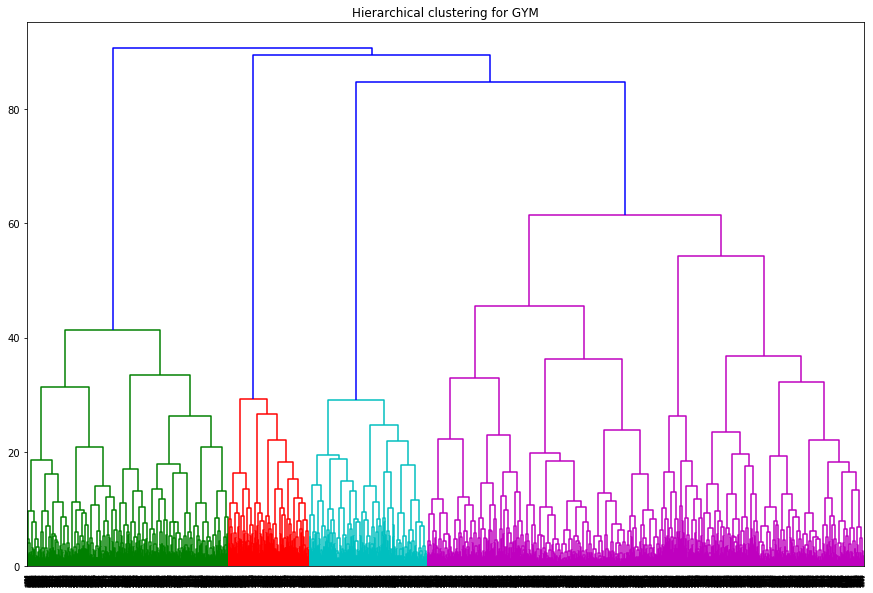

In [20]:
# Standardize the data
sc = StandardScaler()
x_sc = sc.fit_transform(X)

# Build a matrix of distances based on the standardized feature matrix
linked = linkage(x_sc, method='ward')

# Plot a dendrogram
plt.figure(figsize=(15,10))
dendrogram(linked, orientation='top')
plt.title('Hierarchical clustering for GYM')
plt.show()

The dendrogram suggests that there are four clusters in the data. 

However, we'll set the number of clusters to 5. Train the clustering model with the K-means algorithm and predict customer clusters.

In [21]:
# Train the clustering model with the K-means algorithm and predict customer clusters. 
km = KMeans(n_clusters = 5, random_state=0)
labels = km.fit_predict(x_sc)

# Add column 'cluster' to the dataset
df['cluster'] = labels

# Look at the mean feature values for clusters
clusters = df.groupby('cluster').mean()
clusters.T

cluster,0,1,2,3,4
gender,0.496447,0.500000,0.500940,0.534260,0.523316
near_location,0.995939,0.000000,1.000000,0.996028,0.862694
partner,0.892386,0.489247,0.217105,0.379345,0.471503
promo_friends,1.000000,0.078853,0.072368,0.009930,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
contract_period,6.922843,2.994624,2.010338,6.208540,4.777202
group_visits,0.524873,0.232975,0.277256,0.538232,0.427461
age,29.606091,28.679211,27.583647,30.699106,29.297927
avg_additional_charges_total,153.424651,137.125763,119.339956,176.259567,144.208179
lifetime,4.283249,2.974910,1.922932,5.415094,3.940415


Also, let's plot distributions of features for the clusters.

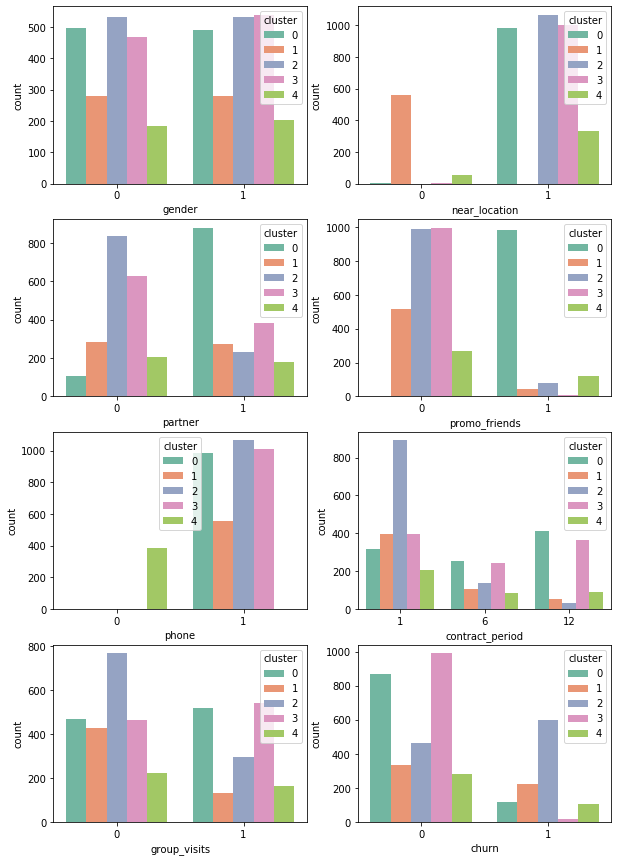

In [22]:
fig , ax = plt.subplots(4,2,figsize=(10,15))

for axis,column in zip(ax.flat,col):
    sns.countplot(x=df[column],hue = df['cluster'], palette = "Set2", ax=axis)
    

We'll plot boxplots for continuous variables.

In [23]:
col2 = ['age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_current_month']

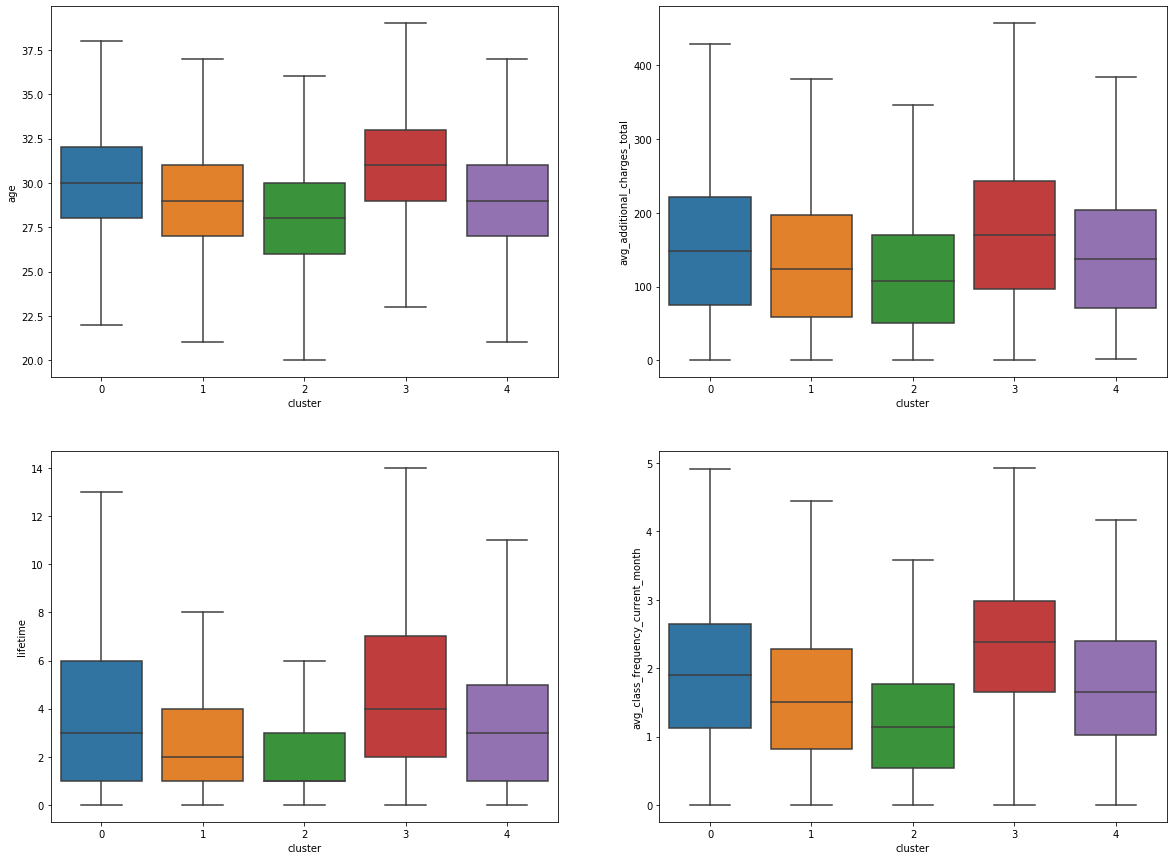

In [24]:
fig , ax = plt.subplots(2,2,figsize=(20,15))

for axis,column in zip(ax.flat,col2):
    sns.boxplot(x=df["cluster"],y = df[column], ax=axis, showfliers=False)

Cluster 0:
* Both genders are represented equally
* All clients live\work near the GYM
* Most clients are employees of a partner company
* All clients left telephone number
* All came through a "bring a friend" offer
* There are subscriptions for 1, 6 and 12 months with approximately equal distribution, but slightly more of 12 months subscriptions
* About equal distribution of clients that visit group sessions and not
* Average age is about 30 years
* High level of average additional charges (153 dollars on average)
* High level of lifetime (about 4 month on average)
* About twice a week they visited a GYM 

Cluster 1:
* Both genders are represented equally
* All clients live\work far from the GYM
* About half of the clients are employees of a partner company
* All clients left telephone number
* There are almost no clients who came through a "bring a friend" offer
* Most clients have 1 month contract
* About 76% of clients don't visit group sessions
* Average age is about 28 years
* Medium level of average additional charges (137 dollars on average)
* On average, lifetime of client is about 3 month
* About 1,5 times a week they visited a GYM 

Cluster 2:
* Both genders are represented equally
* All clients live\work near the GYM
* About 20% of clients are employees of a partner company
* All clients left telephone number
* There are almost no clients who came through a "bring a friend" offer
* Most clients have 1 month contract
* About 72% of clients don't visit group sessions
* Average age is about 27 years
* Low level of average additional charges (119 dollars on average)
* On average, lifetime of client is about 2 month
* About ones a week they visited a GYM 

Cluster 3:
* Slightly larger number of people of one gender compared to the other 
* Almost all clients live\work near the GYM
* About 38% of clients are employees of a partner company
* All clients left telephone number
* There are almost no clients who came through a "bring a friend" offer
* There are subscriptions for 1, 6 and 12 months with approximately equal distribution, but slightly less amount of 6 months subscriptions
* About 54% of clients visited group sessions
* Average age is about 30,5 years
* The highest level of average additional charges (176 dollars on average)
* On average, lifetime of client is about 5 month
* About 2-2,5 times a week they visited a GYM

Cluster 4:
* Slightly larger number of people of one gender compared to the other 
* About 86% clients live\work near the GYM
* About 47% of clients are employees of a partner company
* Clients didn't leave telephone number
* 30% clients came through a "bring a friend" offer
* There are subscriptions for 1, 6 and 12 months with approximately equal distribution, but more 1 month subscriptions
* About 43% of clients visited group sessions
* Average age is about 29 years
* Medium level of average additional charges (144 dollars on average)
* On average, lifetime of client is about 4 month
* Slightly less than twice a week they visited a GYM
  

Let's calculate the churn rate for each cluster.

In [25]:
churn_rate_per_cluster = round((df.groupby('cluster')['churn'].mean()*100),2)
churn_cluster = pd.DataFrame(churn_rate_per_cluster)
churn_cluster.columns = ['churn rate, %']
churn_cluster

,"churn rate, %"
cluster,
0,11.98
1,40.32
2,56.39
3,1.49
4,26.68


We can see that the highest churn rate has cluster 2 (56,39%), then goes cluster 1 (40,32%), then cluster 4 with 26,58% churn rate. Cluster 0 has about 12% churn rate. The leader is the cluster 3 that has the lowest churn rate - 1,49%. 

####  Conclusions and recommendations<a class="anchor" id="chapter5"></a>

Our data consists of 4,000 entries, 14 columns: 13 features and one target variable ("Churn"). 

After studing the data, we draw some conclusions: 

* Both genders are equally represented in the dataset
* 84% of clients live\work near the GYM
* About half of the clients are employees of a partner company
* 30% of the clients came through a "bring a friend" offer
* 90% of clients left their phone number
* Most of the clients have 1-month contract period
* 41% take part in group sessions
* The age of the clients varies from 18 to 41. The average age is 29 years.
* Most clients tend to spend less than 200 (let's assume dollars) on other gym services: cafe, athletic goods, cosmetics, massages, etc. On average, they spend about 130 dollars in total.
* Most clients have 1 month left till the end of the contract
* Most clients stay with GYM for three month
* On average, clients visit GYM 2 times a week.
* We have 27% of clients that left the company, 73% - stayed with company. Our data is imbalanced.

In terms of customer churn, we came to the following conclusion: 

* Gender does not affect the decision to leave the Gym
* Most clients that live\work far from the GYM left
* Clients that are not employees of a partner company more likely to leave
* Those who are not "promo freinds" more likely to leave
* Clients who have 1 month contract more likely to leave
* Those who don't participate in groups visits more likely to leave
* Average age of clients that are loyal to the GYM is about 30 years, and among those who leave - about 27 years.
* On average, those who spent less on additional services left
* On average, those who left the company stayed for 1 month. The clients who do not churn, they tend to stay for a longer period (on average 5 months)
* On average, those who come twice a week stay. Those who left came less than twice a week.

In order to predict customer churn, we used two models: Logistic Regression and Random Forest Classifier. Logistic Regression gave us higher score for all five metrics.

 Accuracy: 0.92,  Precision: 0.85,  Recall: 0.84,  F1: 0.84,  ROC_AUC: 0.97
 
We created five clusters:

* Cluster 0: these are clients whose average age is 30, that live\work near the GYM, most of whom come from partner companies and all through "bring a friend" promotions, with a subscription for 1, 6 and 12 months in approximately equal proportions with a slight prevalence of 12 months, about half of them attend group classes, with a high level of average additional payments (cafe, athletic goods, cosmetics, massages, etc.), they visit GYM about twice a week, lifetime is about 4 month on average. 

Cluster 0: 12% churn rate.  

* Cluster 1: these are clients whose average age is 28, that live\work far from the GYM, about half of them come from partner companies and not come through "bring a friend" promotions, most clients have 1 month contract, most of them don't visit group classes, with a medium level of average additional payments, they visit GYM less than twice a week, lifetime is about 3 month on average. 

Cluster 1: 40% churn rate. 

* Cluster 2: these are clients whose average age is 27, that live\work near the GYM, about 20% of them come from partner companies, almost no one come through "bring a friend" promotions, most clients have 1 month contract, most of them don't visit group classes, with a low level of average additional payments, they visit GYM about once a week, lifetime is about 2 month on average. 

Cluster 2: 56% churn rate.


* Cluster 3: these are clients whose average age is 30,5, that live\work near the GYM, less than a half come from partner companies and almost no one come through "bring a friend" promotions, with a subscription for 1, 6 and 12 months in approximately equal proportions, but slightly less amount of 6 months subscriptions, about half of them attend group classes, with a high level of average additional payments, they visit GYM about twice a week, lifetime is about 5 month on average. 

Cluster 3: 1% churn rate. 

* Cluster 4: these are clients whose average age is 29, most of them live\work near the GYM, about half come from partner companies and 30% come through "bring a friend" promotions, with a subscription for 1, 6 and 12 months in approximately equal proportions, but more 1 months subscriptions, 43% attend group classes, with a medium level of average additional payments, they visit GYM less than twice a week, lifetime is about 4 month on average. 

Cluster 4: 27% churn rate. 

Cluster 3 is the best group of clients, it has the lowest churn rate - 1%. 

#### Recommendations:

* Attracting new clients from nearby areas (distribution of flyers in these areas, advertising billboards)

* Encourage clients to buy subscriptions for a longer period (we saw that customers with 6, 12 month contracts are more loyal to the company). Introduce 3 month contract and set more attractive prices for long-term contracts. 3 month contract could help us avoid customer churn in the beginning

* Encourage clients to attend group sessions (usually people keep going to the gym because of friends) and using additional services (by offering free one-time additional service, one free group lesson etc.)

* It's better to cancel "bring a friend" promotions and special offer for partners, since it does not help retain a client. 
